# note 02. DQN : Atari: Breakout
- Class Date : 23. 10. 20.

<font color="red"> If GPU cannot be allocated due to high usage, change it to CPU.

While CPU is slower than GPU (about 1~1.5 times), it can still works well.
</font>

**Breakout environment** is based on the 1976 Atari arcade game "Breakout." In this setup, the goal for the agent is to control a paddle to hit a ball, breaking a wall of bricks.
In Breakout, there's a paddle at the bottom, a ball, and a wall of bricks at the top. The ball moves around, bouncing off walls, bricks, and the paddle.
- The observation from the environment is a 128-dimensional vector representing the internal state of the frame, including position and velocity of ball, location of paddle, and the remaining bricks. (We may use the game screen as the observation, it takes quite long time to training!..)
- The agent can control the system by taking one of 3 actions: fire, move left, move right.
- A reward 1 is provided if the agent breaks a brick.
- If one of the following condition is met, the episode ends.
    - All bricks broken.
    - Lost 5 lives.

1. Start with installing required packages and importing libraries

In [1]:
# https://stackoverflow.com/questions/76129688/why-is-pip-install-gym-failing-with-python-setup-py-egg-info-did-not-run-succ
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install gym[atari,accept-rom-license]==0.21.0 # ==0.19.0
!apt-get install -y xvfb python-opengl ffmpeg
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install moviepy==0.2.3.5
!pip install ale-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.2
    Uninstalling wheel-0.41.2:
      Successfully uninstalled wheel-0.41.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616798 sha256=f3336b5b9e1d014f2bb751528ef42b9e17c445a52260e1bf7534cfe2789e17f8
  Stored in directory: /root/.cache/pip/wheels/81/aa/90/b67df76370d3916a2189b662cf48da38ce41a4e7e58b6abff5
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=f0474a8bfebd6142e1e02913a0da4d7cc79ca43ee68a9e08ae00df2fee545dcf
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built gym AutoROM.a

In [4]:
import random
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math
import cv2
import time

import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable


import glob
import io
import base64
from IPython.display import HTML, clear_output
from IPython import display as ipythondisplay
from colabgymrender.recorder import Recorder
import os
import sys
import gym                                    # this is for RL environment (https://gym.openai.com/)
from collections import deque               # this simplifies the implementation of the replay buffer



# For reproducibility, set seed for random functions.
SEED = 0

# set seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
filepath = "./"  # Change this path for your Google drive setting.
sys.path.append(filepath)
experiment = "Breakout_DQNScratch"

if not os.path.exists(f"{filepath}"):
    os.makedirs(f"{filepath}")
if not os.path.exists(f"{filepath}/{experiment}"):
    os.makedirs(f"{filepath}/{experiment}")

2. Visualize the environment with random actions

In [6]:
ENV_NAME = "Breakout-ramDeterministic-v4"

env = gym.make(ENV_NAME)
directory = './video'
env = Recorder(env, directory)

env.reset()
_, _, _, info = env.step(0)
max_life = info['lives']
terminal = False
while not terminal:
  action = env.action_space.sample()
  observation, reward, terminal, info = env.step(action)

env.play()


3. Let's define our Q-network.

In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc = nn.Linear(state_size, 128)     # four-dimensional observation ([position of cart, velocity of cart, angle of pole, rotation rate of pole])
        self.fc1 = nn.Linear(128, 128)   # hidden layer
        self.fc2 = nn.Linear(128, 128)   # hidden layer
        self.fc3 = nn.Linear(128, 128)   # hidden layer
        self.fc4 = nn.Linear(128, action_size)    # two possible actions (left-right)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)

        return x


4. Let's define ReplayMemory that stores (state, action, reward, next_state).

In [8]:
class ReplayMemory(object):
    """Facilitates memory replay."""

    def __init__(self, buffer_size):
        self.memory = deque(maxlen=buffer_size)

    def append(self, m):
        self.memory.append(m)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return map(lambda x: Variable(torch.cat(x, 0).to(device)), zip(*batch))

5. Here are our hyperparameters and replay buffer.

Change following parameters and find best settings!
1. **Buffer size (unit : number of (s, a, r, s') transactions)** ▶ **Try 50~1000000**
  - The buffer_size sets the capacity of the replay buffer, storing recent transitions (s, a, r, s').
  - If buffer_size is too large, it requires a lot of memory.
  - If buffer_size is too small, DQN samples correlated transitions, which hinders training.
2. **Explore step (unit : number of (s, a, r, s') transactions)** ▶ **Try 50~500000**
  - We use linear decay for epsilon in the epsilon-greedy algorithm.
  - It starts at `epsilon_init` and decreases to `epsilon_min` after `explore_step` transitions.
  <div>
<img src="https://drive.google.com/uc?export=view&id=1WaDVnmWbsMFlmmQvCHwecu0HLcfkLC-U" width="450"/>
</div>
  - If `explore_step` is too large, the agent mainly do **exploration**, and training will take too long.
  - If `explore_step` is too small, the agent can't explore enough, leading to poor performance.
3. **Target interval (unit : number of (s, a, r, s') transactions)** ▶ **Try 50~5000**
  - This parameter determines how often the target network is updated.
  - A larger target_interval means the target network is updated less frequently.
  - If `target_interval` is too large, training can be slower, but it can be more stable.
  - If `target_interval` is too small, training might be faster, but it can be less stable and may not converge effectively.

In [9]:
buffer_size = 50
explore_step = 50
target_interval = 50

Do not necessarily modify following parameters!

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"


fill_buffer = 10000 # number of initial random (s, a, r, s') pairs before training
batch_size = 32

learn_interval = 1 # 4 # interval of updating Q
lr = 0.0005

save_interval = 100 # interval of saving trained model

# Hyperparameters for epsilon-greedy algorithm
epsilon_init = 1.0
epsilon_min = 0.05

epsilon_delta = (epsilon_init - epsilon_min) / explore_step # We will linearly decrease epsilon.
epsilon = epsilon_init

discount = 0.99 # discount factor

max_episodes = 1000

action_size = 3 # env.action_space.n

action_idx = np.arange(action_size)
probability = np.zeros(action_size, np.float32)

memory = ReplayMemory(buffer_size)

Let's visualize the epsilon value, which linearly decreases.

Text(0, 0.5, 'Epsilon')

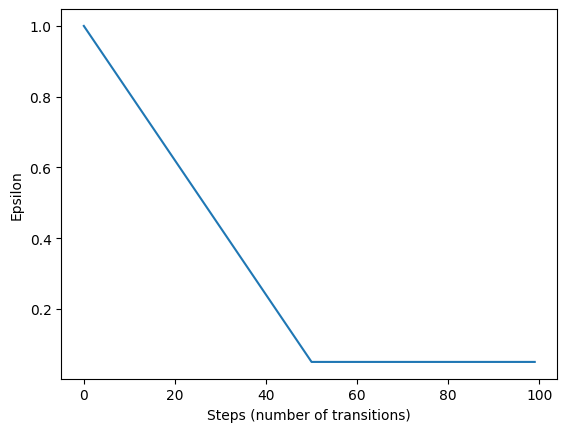

In [11]:
epsilons = []

for t in range(explore_step*2):
    current_epsilon = max(epsilon - epsilon_delta * t, epsilon_min)
    epsilons.append(current_epsilon)

plt.figure()
plt.plot(np.arange(explore_step*2), epsilons)
plt.xlabel('Steps (number of transitions)')
plt.ylabel('Epsilon')

6. Let's initialize our networks (Q-network & target network).

In [12]:
Q = QNetwork(128, action_size).to(device)
Q_target = QNetwork(128, action_size).to(device)
optimizer = torch.optim.Adam(Q.parameters(), lr=lr)
criterion = nn.SmoothL1Loss()

7. Here is function that select the action with epsilon-greedy algorithm and get next state, reward, and done.

In [13]:
def env_reset():
    return torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0)

def act(state, epsilon, ter):
    # epsilon-greedy algorithm
    probability.fill(epsilon / action_size)
    with torch.no_grad():
        qvalues, argq = Q(state.to(device)).data.cpu().max(1)
        probability[argq.item()] += 1 - epsilon

        action = np.random.choice(action_idx, p=probability)

        if ter:
            action = 0

        next_state, reward, done, info = env.step(action + 1)

        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        memory.append(
            (state, torch.LongTensor([int(action)]), torch.Tensor([reward]), next_state, torch.Tensor([done]))
        )
        return next_state, reward, done, action, info # qvalues.item()

8. Define a function to keep track of the performance.

In [14]:
def plt_history():
    clear_output(True)
    plt.figure(figsize=[10, 5])
    plt.subplot(1, 2, 1)
    plt.title("Reward history")
    line1, = plt.plot(reward_history)
    line2, = plt.plot(reward_best_history)
    plt.legend(handles=(line1, line2), labels=('reward', 'best_reward'))

    plt.subplot(1,2,2)
    plt.title("Loss history")
    plt.plot(loss_history)
    target_update_loss = []
    for i in target_update_episode_history:
        target_update_loss.append(loss_history[i])
    plt.scatter(target_update_episode_history, target_update_loss, c='r', s=3)

    plt.grid()
    plt.show()

##Train
Let's start training DQN.

9. Fill replaymemory with random actions.

In [15]:
print(f"init replay memory with {fill_buffer} entries")

state = env_reset()
for _ in range(fill_buffer):
    next_state, _, done, _, _ = act(state, epsilon, False)
    state = env_reset() if done else next_state

print(f"Current length of memory : {len(memory.memory)}")

init replay memory with 10000 entries
Current length of memory : 50


10. Training loop.

We randomly samples a batch of $ (S, A, R, S')$ from the replay
buffer and then calculate the following loss and to perform back-propagation.

$$ \mathcal{L} = (Q(s,a) - \mathbb{E}[r+ \gamma Q_{target}(s',a')])^2  $$

For example, we may obtain like this!

<div>
<img src="https://drive.google.com/uc?export=view&id=1ZwF7FIrevL9_JNqFugf-rjEub-w7uxid" width="700"/>
</div>

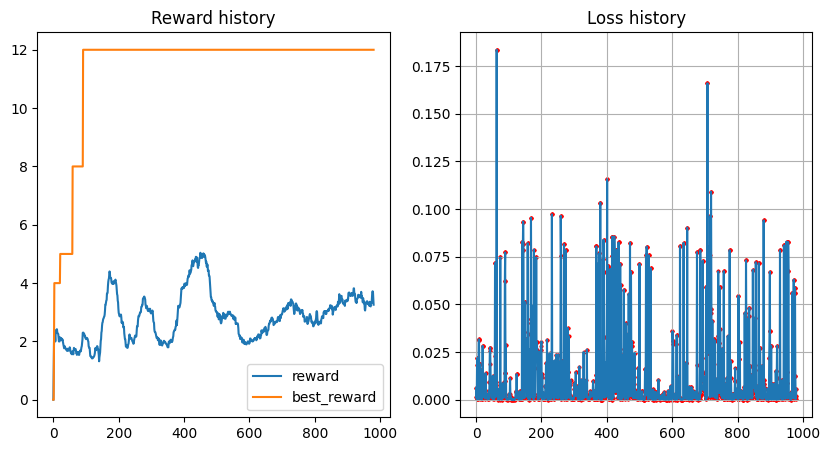

episode 980 (195201): time 2.10s mem 50 eps 0.05000 len 123 r 0.000 avg_r 3.260
episode 981 (195324): time 1.15s mem 50 eps 0.05000 len 123 r 0.000 avg_r 3.200
episode 982 (195522): time 1.84s mem 50 eps 0.05000 len 198 r 2.000 avg_r 3.180
episode 983 (195674): time 1.50s mem 50 eps 0.05000 len 152 r 1.000 avg_r 3.100
episode 984 (195942): time 2.54s mem 50 eps 0.05000 len 268 r 11.000 avg_r 3.320
episode 985 (196155): time 1.96s mem 50 eps 0.05000 len 213 r 3.000 avg_r 3.360
episode 986 (196337): time 2.25s mem 50 eps 0.05000 len 182 r 2.000 avg_r 3.380
episode 987 (196604): time 2.57s mem 50 eps 0.05000 len 267 r 4.000 avg_r 3.400
episode 988 (196786): time 1.67s mem 50 eps 0.05000 len 182 r 2.000 avg_r 3.420
episode 989 (196968): time 1.75s mem 50 eps 0.05000 len 182 r 2.000 avg_r 3.440
episode 990 (197150): time 1.63s mem 50 eps 0.05000 len 182 r 2.000 avg_r 3.480
episode 991 (197418): time 2.55s mem 50 eps 0.05000 len 268 r 4.000 avg_r 3.500
episode 992 (197664): time 2.92s mem 50

In [16]:
t = 0
recent_rewards = deque(maxlen=50)
recent_maxqs = deque(maxlen=50)

reward_history = []
reward_best_history = []
loss_history = []

target_update_episode_history = []

best_rewards = 0.0

for ep in range(max_episodes):
    state = env_reset()

    done = False

    ep_len = 0

    start_time = time.time()

    score = 0

    ter = True
    life = 6

    while not done:
        if t % target_interval == 0:
            Q_target.load_state_dict(Q.state_dict())
            target_update_episode_history.append(ep)

        # linear epsilon decay
        current_epsilon = max(epsilon - epsilon_delta * t, epsilon_min)

        if ter:
            next_state, reward, done, action, info = act(state, current_epsilon, True)
            ter = False
        else:
            next_state, reward, done, action, info = act(state, current_epsilon, False)
        if info['lives'] < life:
            ter = True
            life = info['lives']
        score += reward
        state = next_state

        t += 1
        ep_len += 1

        if ep_len % learn_interval == 0:
            states, actions, rewards, next_states, dones = memory.sample(batch_size)

            pred = Q(states).gather(1, actions.unsqueeze(1)).squeeze(1)

            target = rewards + (1 - dones) * discount * Q_target(next_states).max(1)[0]

            loss = criterion(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # measuring stuffs.
    recent_rewards.append(score)
    recent_average_reward = np.mean(recent_rewards)
    reward_history.append(recent_average_reward)
    reward_best_history.append(best_rewards)
    loss_history.append(loss.item())


    # save the best model
    # Note that best reward can be occur while epsilon is big, which occured by chance.
    if score > best_rewards:
        best_rewards = score
        torch.save(Q.state_dict(), f"{filepath}/{experiment}/best_reward_Q.pt")

    # Since it is for demo, let's end if recent average reward goes bigger than 15.
    # This model may do better than "best_reward_Q_{ep}.pt".
    if recent_average_reward > 15:
        torch.save(Q.state_dict(), f"{filepath}/{experiment}/best_Q.pt")
        plt_history()
        break

    # Save the Q, Q_target, and optimizer every save_interval.
    if ep % save_interval == 0 or ep == max_episodes - 1:
        torch.save(Q.state_dict(), f"{filepath}/{experiment}/Q_{ep}.pt")
        torch.save(Q_target.state_dict(), f"{filepath}/{experiment}/Q_target_{ep}.pt")
        torch.save(optimizer.state_dict(), f"{filepath}/{experiment}/optimizer_{ep}.pt")

    # Plot history.
    if ep % 20 == 0:
        plt_history()


    print(
        "episode %d (%d): time %.2fs mem %d eps %.5f len %d r %.3f avg_r %.3f"
        % (
            ep,
            t,
            time.time() - start_time,
            len(memory.memory),
            current_epsilon,
            ep_len,
            score,
            recent_average_reward
        )
    )


env.close()

##Evaluate
11. Now, let's test the performance of the trained network!

In [17]:
#Evaluate

model_path = f"{filepath}/{experiment}/best_reward_Q.pt"

Q.load_state_dict(torch.load(model_path))

ENV_NAME = "Breakout-ramDeterministic-v4"
# Pong-v0

env_vis = gym.make(ENV_NAME)
directory = './video'
env_vis = Recorder(env_vis, directory)
env_vis.seed(SEED + 1)


def env_vis_reset():
    # after env. is initialized, repeat 4 initial observation to make initial state.
    return torch.tensor(env_vis.reset(), dtype=torch.float32).unsqueeze(0)

def act_vis(state, epsilon, ter):
    # epsilon-greedy algorithm
    probability.fill(epsilon / action_size)
    with torch.no_grad():
        qvalues, argq = Q(state.to(device)).data.cpu().max(1)
        probability[argq.item()] += 1 - epsilon

        action = np.random.choice(action_idx, p=probability)

        if ter:
            action = 0

        next_state, reward, done, info = env_vis.step(action + 1)

        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        return next_state, reward, done, action, info # qvalues.item()



for i in range(4):
    state = env_vis_reset()

    current_epsilon = 0.1

    done = False
    score = 0

    ter = True
    life = 6

    while not done:
        with torch.no_grad():
            if ter:
                next_state, reward, done, action, info = act_vis(state, current_epsilon, True)
                ter = False
            else:
                next_state, reward, done, action, info = act_vis(state, current_epsilon, False)
            if info['lives'] < life:
                ter = True
                life = info['lives']

            score += reward
            state = next_state

            # env_vis.render()


    print(f'Reward is {score}.')

    env_vis.play()

Reward is 3.0.


Reward is 1.0.


Reward is 3.0.


Reward is 7.0.


  warnings.warn("Warning: in file %s, "%(self.filename)+

